--2021-11-17 16:53:44--  https://github.com/giovannipcarvalho/banana-ripeness-classification/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/giovannipcarvalho/banana-ripeness-classification/zip/refs/heads/master [following]
--2021-11-17 16:53:44--  https://codeload.github.com/giovannipcarvalho/banana-ripeness-classification/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/bananas.zip’

/tmp/bananas.zip        [         <=>        ]  38.86M  20.5MB/s    in 1.9s    

2021-11-17 16:53:46 (20.5 MB/s) - ‘/tmp/bananas.zip’ saved [40752650]

Found 256 files belonging to 3 classes

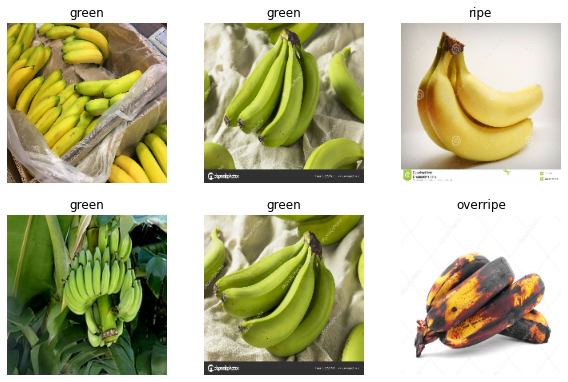

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras import layers
from keras.layers import Dense 
from keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


import zipfile,os


!wget --no-check-certificate \
    "https://github.com/giovannipcarvalho/banana-ripeness-classification/archive/refs/heads/master.zip" \
    -O "/tmp/bananas.zip"


zip_ref = zipfile.ZipFile('/tmp/bananas.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

images_dir = '/tmp/banana-ripeness-classification-master/data'

img_height,img_width=200,200
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  images_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  images_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names=train_ds.class_names
print(class_names)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")




In [2]:
from keras.layers import BatchNormalization
from sklearn.svm import LinearSVC

resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(200,200,3),
                   pooling='avg',classes=3,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

resnet_model.add(Flatten())
resnet_model.add(BatchNormalization())
resnet_model.add(Dense(32, activation='relu'))
resnet_model.add(Dense(32, activation='relu'))
resnet_model.add(Dense(16, activation='softmax'))

resnet_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                        

In [3]:

resnet_model.compile(optimizer=Adam(learning_rate=0.01),loss='sparse_categorical_crossentropy')
history = resnet_model.fit(train_ds, epochs=25)

Epoch 1/25
7/7 [==============================] - 33s 4s/step - loss: 1.4708
Epoch 2/25
7/7 [==============================] - 29s 4s/step - loss: 0.3167
Epoch 3/25
7/7 [==============================] - 29s 4s/step - loss: 0.2034
Epoch 4/25
7/7 [==============================] - 29s 4s/step - loss: 0.0791
Epoch 5/25
7/7 [==============================] - 29s 4s/step - loss: 0.0479
Epoch 6/25
7/7 [==============================] - 29s 4s/step - loss: 0.0854
Epoch 7/25
7/7 [==============================] - 29s 4s/step - loss: 0.0430
Epoch 8/25
7/7 [==============================] - 29s 4s/step - loss: 0.0409
Epoch 9/25
7/7 [==============================] - 29s 4s/step - loss: 0.0269
Epoch 10/25
7/7 [==============================] - 29s 4s/step - loss: 0.0385
Epoch 11/25
7/7 [==============================] - 29s 4s/step - loss: 0.0280
Epoch 12/25
7/7 [==============================] - 29s 4s/step - loss: 0.0750
Epoch 13/25
7/7 [==============================] - 29s 4s/step - loss: 0.

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  images_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=205)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  images_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=51)


Found 256 files belonging to 3 classes.
Using 205 files for training.
Found 256 files belonging to 3 classes.
Using 51 files for validation.


In [5]:
image, label = next(iter(train_ds))
label=label.numpy()

x_train = resnet_model.predict(image)


In [6]:
x_test,y_test = next(iter(val_ds))
y_test = y_test.numpy()

x_test = resnet_model.predict(x_test)


In [7]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train,label)
knn_pred = knn.predict(x_test)

In [8]:
from sklearn.metrics import accuracy_score

knn_accuracy = accuracy_score(y_test, knn_pred)
print('Accuracy (RES + KNN): ', "%.2f" % (knn_accuracy*100))


Accuracy (RES + KNN):  88.24


In [9]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

KeyError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
"""
from google.colab import files
uploaded = files.upload()
for k, v in uploaded.items():
    open(k, 'wb').write(v)

import cv2
img = cv2.imread("Add Your File Name Here")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

img = cv2.resize(img,(200,200))
img = np.array(img)

print(img.shape)

resnet_model.predict(img)
"""